<a href="https://colab.research.google.com/github/mdaliuddinhyder04/Cat-Vs-Dog-Image-Classification/blob/main/Dog_Cat_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle competitions download -c dogs-vs-cats

 97% 788M/812M [00:09<00:00, 121MB/s]
100% 812M/812M [00:09<00:00, 86.8MB/s]


In [4]:
#importing libraries
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [5]:
#image properties
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [10]:
zip_ref = zipfile.ZipFile('test1.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [9]:
zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [15]:
#datasetfor training
filenames=os.listdir("./train")

categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [16]:
#datasetfor test
filenames=os.listdir("./test1")

categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)

test_df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [17]:
test_df['category'].nunique()

1

In [18]:
#neural network
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

In [19]:
#analysing neural network
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [20]:
#callbacks and learning rate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [21]:
#dataframe management
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [22]:
test_df

,filename,category
0,12381.jpg,0
1,11235.jpg,0
2,12425.jpg,0
3,4727.jpg,0
4,9375.jpg,0
...,...,...
12495,7559.jpg,0
12496,7459.jpg,0
12497,5091.jpg,0
12498,11356.jpg,0


In [26]:
train_path = r'/content/train'
test_path = r'/content/test1'

In [36]:
#data generation
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "./train",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "./train",
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)

test_generator =  test_datagen.flow_from_directory(test_path, target_size = (*Image_Size, *Image_Size), class_mode = 'binary',
                                             batch_size = 32)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [37]:
#training
epochs=10
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10


<ipython-input-37-b19d6ba5bc7e>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1333/1333 [==============================] - ETA: 0s - loss: 0.7497 - accuracy: 0.6311

1333/1333 [==============================] - 145s 99ms/step - loss: 0.7497 - accuracy: 0.6311 - val_loss: 0.5531 - val_accuracy: 0.7323 - lr: 0.0010
Epoch 2/10
1333/1333 [==============================] - ETA: 0s - loss: 0.5791 - accuracy: 0.7006

1333/1333 [==============================] - 134s 101ms/step - loss: 0.5791 - accuracy: 0.7006 - val_loss: 0.7232 - val_accuracy: 0.6793 - lr: 0.0010
Epoch 3/10
1333/1333 [==============================] - ETA: 0s - loss: 0.5305 - accuracy: 0.7418

1333/1333 [==============================] - 134s 101ms/step - loss: 0.5305 - accuracy: 0.7418 - val_loss: 0.5150 - val_accuracy: 0.7640 - lr: 0.0010
Epoch 4/10
1333/1333 [==============================] - ETA: 0s - loss: 0.4996 - accuracy: 0.7637

1333/1333 [==============================] - 129s 97ms/step - loss: 0.4996 - accuracy: 0.7637 - val_loss: 0.5399 - val_accuracy: 0.7566 - lr: 0.0010
Epoch 5/10
1333/1333 [==============================] - ETA: 0s - loss: 0.4710 - accuracy: 0.7828

1333/1333 [==============================] - 138s 103ms/step - loss: 0.4710 - accuracy: 0.7828 - val_loss: 0.4617 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 6/10
1333/1333 [==============================] - ETA: 0s - loss: 0.4539 - accuracy: 0.7889

1333/1333 [==============================] - 131s 98ms/step - loss: 0.4539 - accuracy: 0.7889 - val_loss: 0.3815 - val_accuracy: 0.8498 - lr: 0.0010
Epoch 7/10
1333/1333 [==============================] - ETA: 0s - loss: 0.4391 - accuracy: 0.7990

1333/1333 [==============================] - 130s 98ms/step - loss: 0.4391 - accuracy: 0.7990 - val_loss: 0.4385 - val_accuracy: 0.7916 - lr: 0.0010
Epoch 8/10
1333/1333 [==============================] - ETA: 0s - loss: 0.4069 - accuracy: 0.8137

1333/1333 [==============================] - 130s 98ms/step - loss: 0.4069 - accuracy: 0.8137 - val_loss: 0.3504 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 9/10
1333/1333 [==============================] - ETA: 0s - loss: 0.3951 - accuracy: 0.8232

1333/1333 [==============================] - 125s 94ms/step - loss: 0.3951 - accuracy: 0.8232 - val_loss: 0.3417 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 10/10
1333/1333 [==============================] - ETA: 0s - loss: 0.3842 - accuracy: 0.8295

1333/1333 [==============================] - 127s 96ms/step - loss: 0.3842 - accuracy: 0.8295 - val_loss: 0.6529 - val_accuracy: 0.7574 - lr: 0.0010


In [38]:
#saving model
model.save("model1_catdog_10epoch.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
#test data
test_filenames = os.listdir("./test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

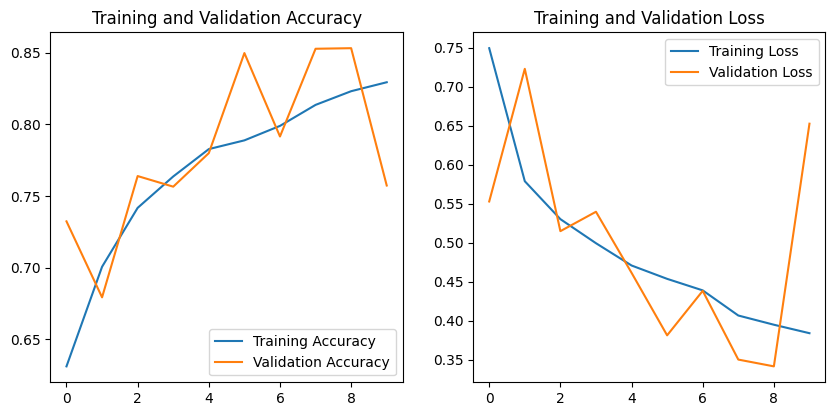

In [43]:
#visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:

model.evaluate(x=train_generator)

1334/1334 [==============================] - 105s 79ms/step - loss: 1.1706 - accuracy: 0.6330


[1.170593500137329, 0.6330000162124634]

In [45]:
test_df

,filename
0,12381.jpg
1,11235.jpg
2,12425.jpg
3,4727.jpg
4,9375.jpg
...,...
12495,7559.jpg
12496,7459.jpg
12497,5091.jpg
12498,11356.jpg


In [46]:
#prediction
predict = model.predict_generator(train_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-46-665ce17d5c8b>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(train_generator, steps=np.ceil(nb_samples/batch_size))


In [47]:
predict = pd.DataFrame(predict)
predict

,0,1
0,0.851799,0.148201
1,0.538721,0.461279
2,0.999782,0.000218
3,0.396709,0.603290
4,0.999994,0.000006
...,...,...
12505,0.944203,0.055797
12506,0.897797,0.102203
12507,0.996213,0.003786
12508,0.991268,0.008733


In [48]:
import pandas as pd
import numpy as np
np.random.seed(10)

remove_n = 1
for i in range(8):
    drop_indices = np.random.choice(predict.index, remove_n, replace=False)
    predict = predict.drop(drop_indices)

predict

,0,1
0,0.851799,0.148201
1,0.538721,0.461279
2,0.999782,0.000218
3,0.396709,0.603290
4,0.999994,0.000006
...,...,...
12505,0.944203,0.055797
12506,0.897797,0.102203
12507,0.996213,0.003786
12508,0.991268,0.008733


In [49]:
predict.drop([1],axis=1,inplace=True)
predict

,0
0,0.851799
1,0.538721
2,0.999782
3,0.396709
4,0.999994
...,...
12505,0.944203
12506,0.897797
12507,0.996213
12508,0.991268


In [50]:
#convertion of labels to categories
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [51]:
test_df

,filename,category
0,12381.jpg,0.0
1,11235.jpg,0.0
2,12425.jpg,0.0
3,4727.jpg,0.0
4,9375.jpg,0.0
...,...,...
12495,7559.jpg,0.0
12496,7459.jpg,0.0
12497,5091.jpg,0.0
12498,11356.jpg,0.0


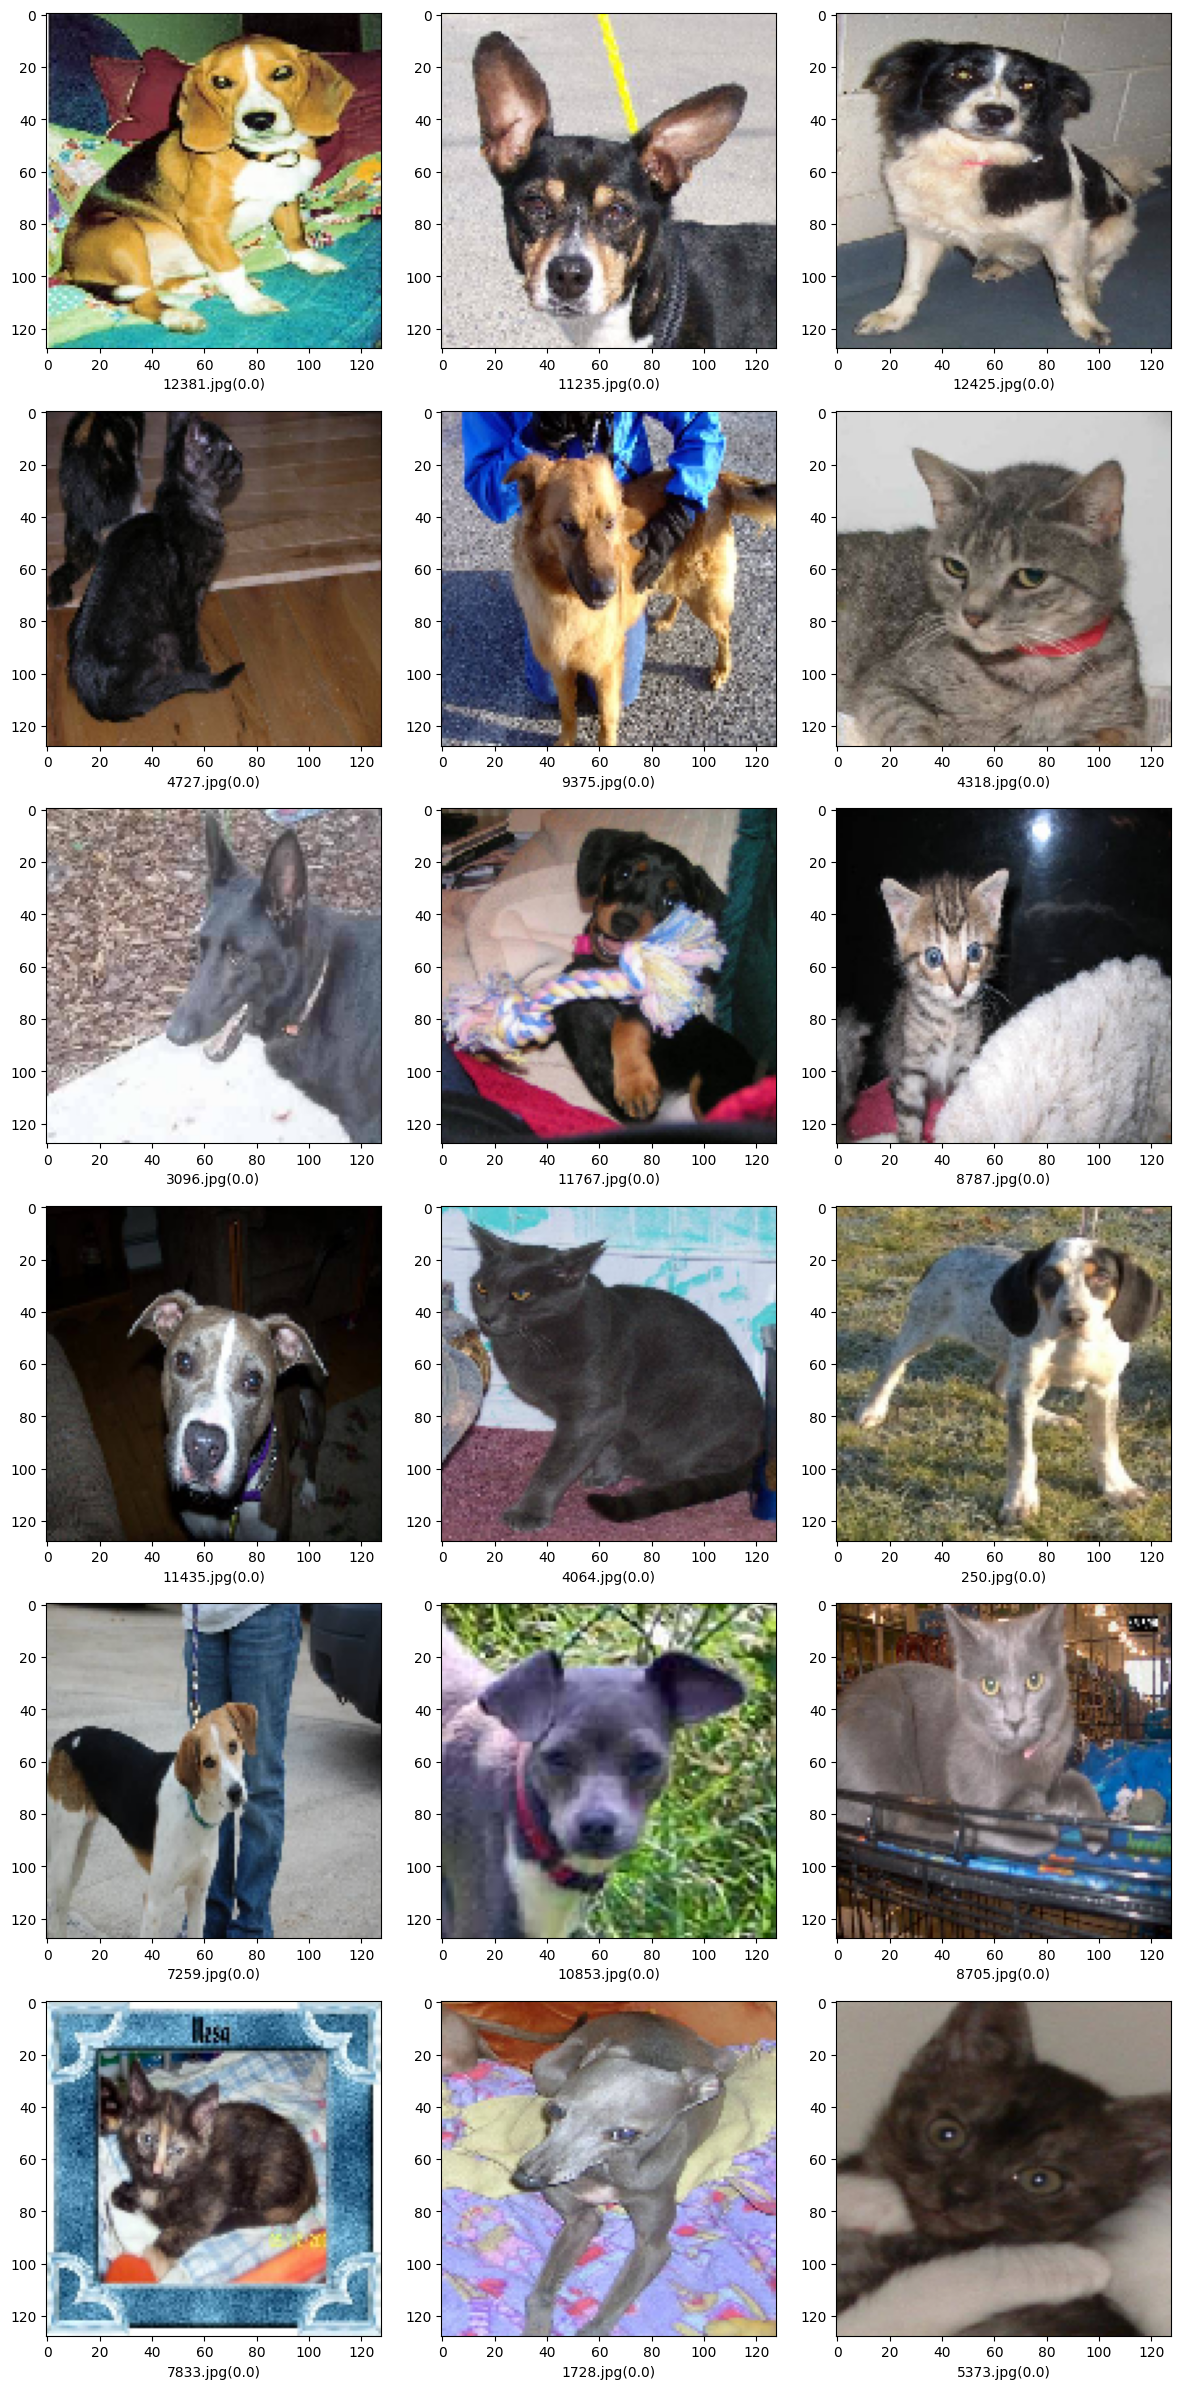

In [60]:
#predicted result
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test1/"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [76]:
# testing in custom data
results = {
    0: 'cat',
    1: 'dog'
}

from PIL import Image
import numpy as np

im = Image.open("/content/test1/250.jpg")
im = im.resize(Image_Size)  # Make sure Image_Size is defined somewhere
im = np.expand_dims(im, axis=0)
im = np.array(im)
im = im / 255

# Assuming 'model' is your Sequential model
predictions = model.predict(im)
pred = np.argmax(predictions, axis=1)[0]

print(pred, results[pred])


1/1 [==============================] - 0s 35ms/step
1 dog
